# Fitting multi-modal empirical data

Fitting multi modal data to known distributions use is done using [Chi2Fit](https://hex.pm/packages/chi2fit).

The source of the data used is a LinkedIn post [5].

## Set-up

In [1]:
alias Chi2fit.Distribution, as: D
alias Chi2fit.Fit, as: F
alias Chi2fit.Statistics, as: S
alias Chi2fit.Utilities, as: U
alias Chi2fit.Gnuplotlib, as: G

Chi2fit.Gnuplotlib

## Data and simulation set-up

As an example consider the lead time of work items.

In [27]:
data = [{2,30},{4,20},{6,50},{8,35},{10,27},{12,11},{14,20},{16,16},{18,2}]
|> Enum.map(fn {x,count}->List.duplicate(x-1,count)++List.duplicate(x-2,count) end)
|> Enum.concat

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]

Other parameters that affect the forecasting are listed below. Please adjust to your needs.

In [38]:
# The size of the backlog, e.g. 100 backlog items
size = 100

# Number of iterations to use in the Monte Carlo
iterations = 1000

# The size of bins for grouping the data
binsize = 1

# Number of probes to use in the chi2 fit
probes = 10_000
:"do not show this result in output"

## Preparation

Next, we convert the throughput data to a histogram. To this end we group the data in bins of size 1 starting at 0.

In [29]:
hdata = S.to_bins(data, {binsize,0}) |> U.as_table({"Bin","Cumulative value","Low","High"})
:"do not show this result in output"

Bin|Cumulative value   |Low                |High               
---|-------------------|-------------------|-------------------
1  |0.07109004739336493|0.05848245994924107|0.08591680793932278
2  |0.14218009478672985|0.12490155152546507|0.1612680839337433 
3  |0.1895734597156398 |0.1700988795014874 |0.21060674476907432
4  |0.23696682464454977|0.21575792658003556|0.2594904490649855 
5  |0.35545023696682465|0.3313521163088033 |0.38026651717980753
6  |0.47393364928909953|0.4485384559848008 |0.49945808829233074
7  |0.556872037914692  |0.5313956143805596 |0.5820664033914438 
8  |0.6398104265402843 |0.614937787598684  |0.6639885501958502 
9  |0.7037914691943128 |0.6798969971385972 |0.7266710956682081 
10 |0.7677725118483413 |0.745380713759201  |0.7888253878593479 
11 |0.7938388625592417 |0.7722385470472404 |0.8139664315296157 
12 |0.8199052132701422 |0.7992202741819272 |0.8389819830878431 
13 |0.8672985781990521 |0.8486684816872775 |0.8840677612266513 
14 |0.9146919431279621 |0.89882754686203

## Mixture: Trimodal fit

Next, we try a combination of three Weibulls to accomodate for the two gaps in the histogram.

In [30]:
penalty = fn _,[w1,w2|_] -> cond do
  w1 < 0 -> 1_000_000_000
  w1 > 1 -> 1_000_000_000
  w2 < 0 -> 1_000_000_000
  w2 > 1 -> 1_000_000_000
  true -> 0
  end
end
:"do not show this result in output"

In [39]:
model = %D.TriModal{distribs: [%D.Weibull{},%D.Weibull{},%D.Weibull{}]}
initial = [{0.0,1.0},{0.0,1.0}|List.duplicate({0.1,20.0},D.size(model)-2)]
:"do not show this result in output"

In [32]:
options = [probes: 100_000, smoothing: false, model: :linear, saved?: true]
result = {_,parameters3,ranges,saved} = F.chi2probe hdata, initial, {D.cdf(model), penalty}, options
U.display result

Initial guess:
    chi2:		50.89288515980597
    pars:		[0.25915760868835025, 0.7492411090766671, 1.592099408808865, 2.3201782302715657, 2.7844598666968072, 8.124775329042656, 9.954365236676788, 14.09096798991696]
    ranges:		{[0.25915760868835025, 0.25915760868835025], [0.7492411090766671, 0.7492411090766671], [1.592099408808865, 1.592099408808865], [2.3201782302715657, 2.3201782302715657], [2.7844598666968072, 2.7844598666968072], [8.124775329042656, 8.124775329042656], [9.954365236676788, 9.954365236676788], [14.09096798991696, 14.09096798991696]}



:ok

In [33]:
options = [{:probes, saved}|options]
result = {_,_,parameters3,_} = F.chi2fit hdata, {parameters3, D.cdf(model), penalty}, 40, options
U.display(hdata,model,result,options)

Final:
    chi2:		3.3306338811122207
    Degrees of freedom:	10
    gradient:		[4.998885393183873e-6, 5.936129571483151e-6, 2.0031914622750263e-7, -1.3538853575500901e-7, 8.476653439213792e-8, -7.92993328032603e-7, -4.9605776282994835e-8, 1.2079518088093428e-7]
    parameters:		[0.21871444048957814, 0.7141457366146093, 0.9123543218922615, 2.5943080238093197, 3.1269685423374893, 6.951343143912313, 8.151148649014004, 14.05842588492204]
    errors:		[0.13479962596757694, 0.10291389246472256, 0.35364380944756363, 2.4223361132068457, 0.7620661394839099, 0.524982938885739, 3.968536926004576, 0.6580167283863516]
    ranges:
			chi2:		3.3306338811122207	-	4.311217406170388
			parameter:	0.18908051455804747	-	0.2620559711271096
			parameter:	0.7122829137823627	-	0.7936785245450322
			parameter:	0.7689964657666617	-	0.9886907516983285
			parameter:	2.4525476870458314	-	3.465916585359323
			parameter:	2.6264655633989578	-	3.190724005402417
			parameter:	6.926472034185152	-	7.209203243424806
			pa

:ok

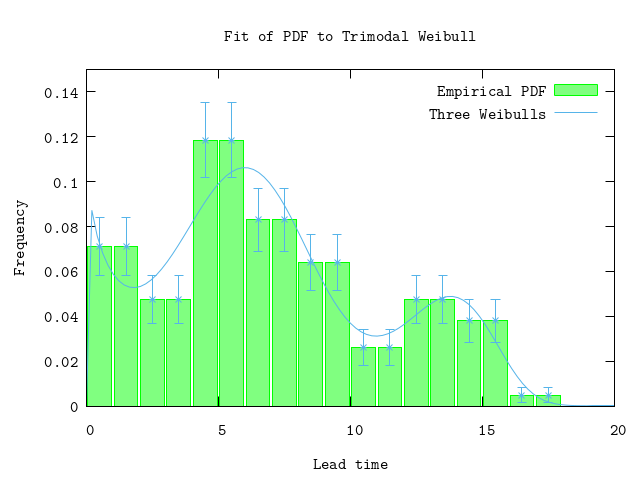

In [35]:
pdf = fn x -> D.pdf(model).(x,parameters3) end
G.pdf(data,
    plottitle: "Fit of PDF to Trimodal Weibull",
    xlabel: "Lead time",
    ylabel: "Frequency",
    xrange: '[0:20]',
    yrange: '[0:0.15]',
    pdf: pdf,
    bin: binsize,
    title: "Three Weibulls")
:"this is an inline image"

## References

[1] _Poisson distribution_, https://en.wikipedia.org/wiki/Poisson_distribution/<br>
[2] _Chi2Fit_, Pieter Rijken, 2018, https://hex.pm/packages/chi2fit<br>
[3] _Asymmetric errors_, Roger Barlow, Manchester University, UK and Stanford University, USA, PHYSTAT2003, SLAC, Stanford, California, September 8-11, 2003, https://www.slac.stanford.edu/econf/C030908/papers/WEMT002.pdf<br>
[4] _Efficient use of Monte Carlo: uncertainty propagation_, D. Rochman et. al., Nuclear Science and Engineering, 2013, ftp://ftp.nrg.eu/pub/www/talys/bib_rochman/fastTMC.pdf<br>
[5] Niladri Bose, LinkedIn post, August 2020